# Image Processing: Filtering

Kevin J. Walchko

create 16 Aug 2017

---

Now that we know how to read in images and manipulate them a little, let's do some image processing. Image processing is processing of images using mathematical operations by using any form of signal processing for which the input is an image, a series of images or a video; the output of image processing may be either an image or a set of characteristics or parameters related to the image. Most image-processing techniques involve isolating the individual color planes of an image and treating them as two-dimensional signal and applying standard signal-processing techniques to them. Images are also processed as three-dimensional signals with the third dimension being time or the z-axis.

## Objectives

- understand noise reduction
- understand edge detection
- understand morphological operators
- understand when to use different filters
- understand how to use thresholding

## References

- [Wikipedia Image Processing](https://en.wikipedia.org/wiki/Image_processing)
- [Wikipedia Convolution](https://en.wikipedia.org/wiki/Convolution)
- [Official OpenCV python tutorials](http://docs.opencv.org/3.1.0/db/d27/tutorial_py_table_of_contents_feature2d.html)
- [Official OpenCV Harris corner detector tutorial](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html)
- [Official OpenCV homography tutorial](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html)
- [Feature detection survey](http://campar.in.tum.de/twiki/pub/Chair/TeachingWs09MATDCV/FT_survey_interestpoints08.pdf)
- [Morphological Operations](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#morphological-ops)
- [OpenCV thresholding](https://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html)

## Setup

In [1]:
%matplotlib inline 

import cv2         # opencv itself
import numpy as np # matrix manipulations
import random

from matplotlib import pyplot as plt           # this lets you draw inline pictures in the notebooks
import pylab                                   # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 10.0) # this controls figure size in the notebook

# Basic Image Operations

When I was young, I use to play Dungeons & Dragons (D&D). A lot of Sci-Fi/Fantasy books, movies, games, pop culture, etc have been influenced by D&D. Let's grab a cool image to play with.

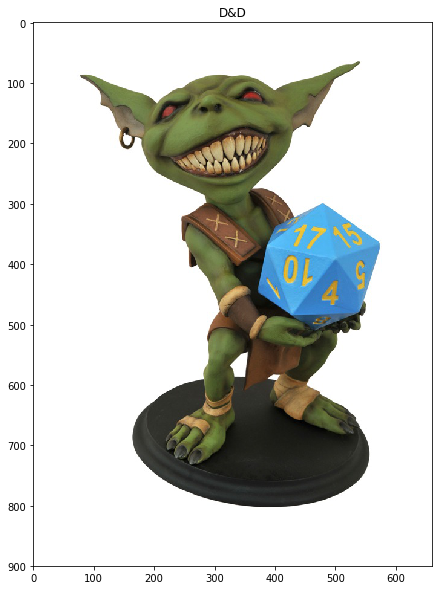

In [2]:
# Let's grab a goblin with a D20 (20 sided dice)
input_image=cv2.imread('dnd.jpg')

# remember, we have to correct the image and display it as RGB
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# plot the image
plt.imshow(input_image)
plt.title('D&D');

## Noise reduction

Noise reduction can take many forms. The first involves blurring/smoothing an image using a Gaussian kernel.
The width of the kernel determines the amount of smoothing. Or put another way, how many pixels are in our window.

Image blurring is achieved by convolving the image with a low-pass filter kernel. It is useful for removing noises. It actually removes high frequency content (eg: noise, edges) from the image. So edges are blurred a little bit in this operation. (Well, there are blurring techniques which doesn’t blur the edges too). OpenCV provides mainly four types of blurring techniques.

1.  **Averaging:** This is done by convolving image with a normalized box filter. It simply takes the average of all the pixels under kernel area and replace the central element. This is done by the function cv2.blur() or cv2.boxFilter(). Check the docs for more details about the kernel. We should specify the width and height of kernel. A 3x3 normalized box filter would look like below:

  $$
  kernel = \frac{1}{9}
  \begin{bmatrix}
      1&1&1\\
      1&1&1\\
      1&1&1
  \end{bmatrix}
  $$ 

  ![](convolution.jpg)
  ![](convolution2.jpg)

2. **Gaussian Blurring:** In this, instead of box filter, gaussian kernel is used. It is done with the function, cv2.GaussianBlur(). We should specify the width and height of kernel which should be positive and odd. We also should specify the standard deviation in X and Y direction, sigmaX and sigmaY respectively. If only sigmaX is specified, sigmaY is taken as same as sigmaX. If both are given as zeros, they are calculated from kernel size. Gaussian blurring is highly effective in removing gaussian noise from the image. If you want, you can create a Gaussian kernel with the function, cv2.getGaussianKernel().

3. **Median Blurring:** Here, the function cv2.medianBlur() takes median of all the pixels under kernel area and central element is replaced with this median value. This is highly effective against salt-and-pepper noise in the images. Interesting thing is that, in the above filters, central element is a newly calculated value which may be a pixel value in the image or a new value. But in median blurring, central element is always replaced by some pixel value in the image. It reduces the noise effectively. Its kernel size should be a positive odd integer.

4. **Bilateral Filtering:** cv2.bilateralFilter() is highly effective in noise removal while keeping edges sharp. But the operation is slower compared to other filters. We already saw that gaussian filter takes the a neighbourhood around the pixel and find its gaussian weighted average. This gaussian filter is a function of space alone, that is, nearby pixels are considered while filtering. It doesn’t consider whether pixels have almost same intensity. It doesn’t consider whether pixel is an edge pixel or not. So it blurs the edges also, which we don’t want to do.

  Bilateral filter also takes a gaussian filter in space, but one more gaussian filter which is a function of pixel difference. Gaussian function of space make sure only nearby pixels are considered for blurring while gaussian function of intensity difference make sure only those pixels with similar intensity to central pixel is considered for blurring. So it preserves the edges since pixels at edges will have large intensity variation.

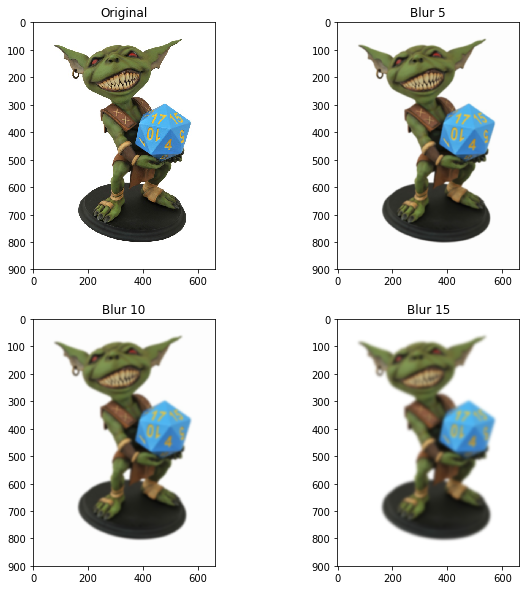

In [3]:
# Gaussian blurring
plt.subplot(2,2,1)
plt.imshow(input_image)
plt.title('Original');

for i in range(1, 4):
    plt.subplot(2,2,i+1)
    d = i*5
    img_blur3 = cv2.GaussianBlur(input_image, (2*d+1, 2*d+1), -1)
    plt.imshow(img_blur3)
    plt.title('Blur {}'.format(d))

# Salt and Pepper Noise

[Salt and pepa](https://en.wikipedia.org/wiki/Salt-N-Pepa) is a good model of a camera which has dead (image value is 0) or hot (image value is max, say 255) pixels in it. Generally manufacturers weed out sensors that have high defects, but there are always some that are bad. Or, cameras that are in use for a long time develop defects ... say imagers on satellites. You cannot replace those easily, so you have to deal with dead pixels.

[array([236, 548, 631, ..., 298, 435, 580]), array([481, 504, 297, ..., 232,  24,  46])]


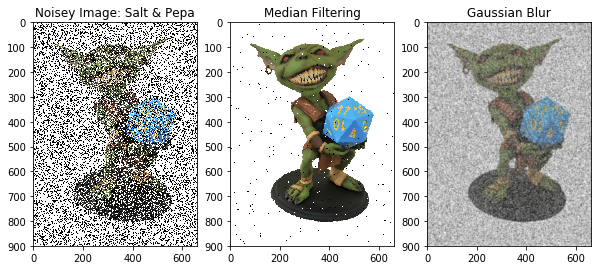

In [4]:
# this isn't really a good way to do salt n pepper noise
# but it makes the point. Also remember, a camera has
# a bayer pattern, so hot/dead pixels won't impact an
# image like I am showing here. I am almost assuming
# there is a red, blue, green image plane capturing the 
# image ... not a bayer patterned sensor
def add_salt_and_pepper(image, s_vs_p):
    row,col,ch = image.shape
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape[:2]]
    print(coords)
    for a,b in zip(*coords):
        out[a,b,:] = np.random.choice([0,255])
    return out

plt.subplot(1,3,1)
nimg = add_salt_and_pepper(input_image, .25)
plt.imshow(nimg);
plt.title('Noisey Image: Salt & Pepa')

plt.subplot(1,3,2)
med = cv2.medianBlur(nimg,5)
plt.imshow(med)
plt.title('Median Filtering');

plt.subplot(1,3,3)
blur = cv2.GaussianBlur(nimg, (11, 11), -1)
plt.imshow(blur)
plt.title('Gaussian Blur');

## Edges

For a lot of what we think of as "modern" computer vision techniques, edge detection functions as a building block. Much edge detection actually works by **convolution**, and indeed **convolutional neural networks** are absolutely the flavor of the month in some parts of computer vision. Sobel's edge detector was one of the first truly successful edge detection (enhancement) technique and that involves convolution at its core. You can read more about the background to Sobel here in the [OpenCV docs](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html). 

The basic process is:

1. Smooth an image to reduce noise, which can effect edge detection.
2. Convolve the image with something like the Sobel vertical ($G_y$) and horizontal edge ($G_x$) detector which gives you the first derivative of the image in those directions. The you can find the gradient and direction for each pixel as:

  $$
  \nabla Edge(G)=\sqrt{G_x^2 + G_y^2} \\
  Angle = \arctan(\frac{G_y}{G_x})
  $$

3. Non-maximum Suppression, which basically checks if each pixel is local maximum in its neighborhood in the direction of gradient. 
  
  ![](nms.jpg)

  Point A is on the edge ( in vertical direction). Gradient direction is normal to the edge. Point B and C are in gradient directions. So point A is checked with point B and C to see if it forms a local maximum. If so, it is kept, otherwise, it is suppressed ( put to zero).

Some kernels used for edge detection are:

  $$
  Sobel_x =
  \begin{bmatrix}
      -1&0&1\\
      -2&0&2\\
      -1&0&1
  \end{bmatrix}\\
  Sobel_y =
  \begin{bmatrix}
      1&2&1\\
      0&0&0\\
      -1&-2&-1
  \end{bmatrix}\\
  Laplacian =
  \begin{bmatrix}
      0&-1&0\\
      -1&4&-1\\
      0&-1&0
  \end{bmatrix}
  $$ 

Hopefully, you can see how the Sobel kernels detect edges in the x-dir or y-dir. The Laplace kernel actually detects edges in both directions. 

Let's do an example:

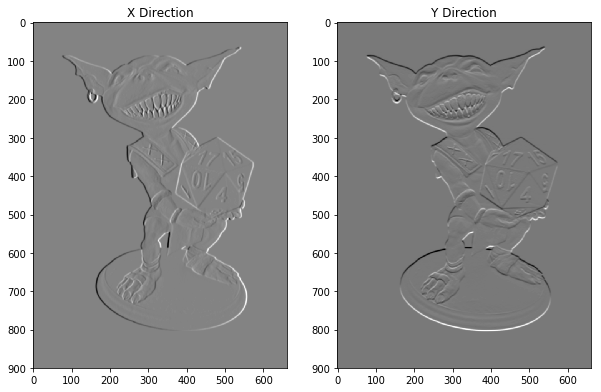

In [5]:
# edge detection is done in grayscale, so make sure you convert
# correctly like: RGB2GRAY or BGR2GRAY
sobelimage=cv2.cvtColor(input_image,cv2.COLOR_RGB2GRAY)

sobelx = cv2.Sobel(sobelimage,cv2.CV_64F,1,0,ksize=9)
sobely = cv2.Sobel(sobelimage,cv2.CV_64F,0,1,ksize=9)

plt.subplot(1,2,1)
plt.imshow(sobelx,cmap = 'gray') 
plt.title('X Direction')

plt.subplot(1,2,2)
plt.imshow(sobely,cmap = 'gray');
plt.title('Y Direction');

For Sobel, see how the higher values (blacks and whites) for the x-direction are oriented on the left/right of the image as the kernel moves over the image? Also, the y-direction, is similar with the values in the up/down direction. You should be able to look at the kernel for each and see how they will react with an image.


## Canny Edge Detection

Canny edge detection is another popular method - it takes two thresholds.
The first one determines how likely Canny is to find an edge, and the second determines how likely it is to follow that edge once it's found. Investigate the effect of these thresholds by altering the values below.

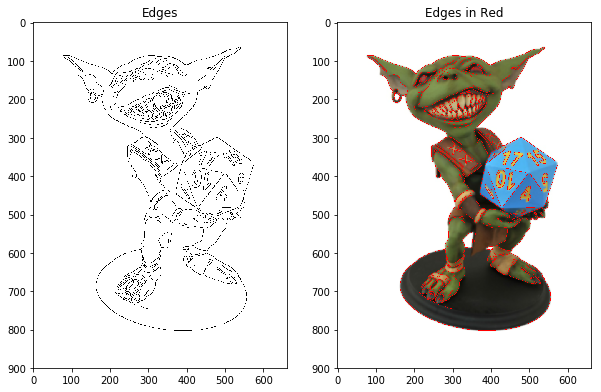

In [6]:
th1=30
th2=60 # Canny recommends threshold 2 is 3 times threshold 1 - you could try experimenting with this...
d=3    # gaussian blur or smoothing is common to eliminate pixel noise in a real camera image

# make a copy so we don't destroy the original
edgeresult=input_image.copy()

# smooth out little pixel noises
edgeresult = cv2.GaussianBlur(edgeresult, (2*d+1, 2*d+1), -1)

# find edges
gray = cv2.cvtColor(edgeresult, cv2.COLOR_BGR2GRAY)
edge = cv2.Canny(gray, th1, th2)

# this takes pixels in edgeresult where edge non-zero colours them
edgeresult[edge != 0] = (255, 0, 0)

plt.subplot(1,2,1)
# invert colors so black on white
plt.imshow(cv2.bitwise_not(edge), cmap='gray')
plt.title('Edges');

plt.subplot(1,2,2)
plt.imshow(edgeresult)
plt.title('Edges in Red');

Behind the scense, face detection and other computer vision operations use these ideas (smoothing, edge detection, color space changes, etc) to do higher level operations.

# Morphological Operators

Often in computer vision, we are trying to delect objects and have advanced algorithms that produce grayscale (think True (255) and False (0)) outputs marking if the algorithm found what it is looking for. However, because of noise, lighting, camera angle, and other reasons you need to clean up your images.

## Erosion

The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object (Always try to keep foreground in white). So what does it do? The kernel slides through the image (as in 2D convolution). A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero).

So what happends is that, all the pixels near boundary will be discarded depending upon the size of kernel. So the thickness or size of the foreground object decreases or simply white region decreases in the image. It is useful for removing small white noises, detaching two connected objects, etc.

## Dilation

It is just opposite of erosion. Here, a pixel element is ‘1’ if atleast one pixel under the kernel is ‘1’. So it increases the white region in the image or size of foreground object increases. Normally, in cases like noise removal, erosion is followed by dilation. Because, erosion removes white noises, but it also shrinks our object. So we dilate it. Since noise is gone, they won’t come back, but our object area increases. It is also useful in joining broken parts of an object.

## Opening

Opening is just another name of erosion followed by dilation. It is useful in removing noise, as we explained above. Here we use the function, `cv2.morphologyEx()`

## Closing

Closing is reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object.

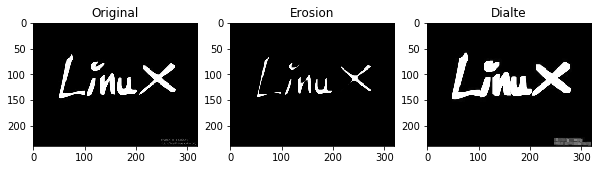

In [7]:
img = cv2.imread('linux.jpg',0)
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(img,kernel,iterations = 1)
dilation = cv2.dilate(img,kernel,iterations = 1)

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original')

plt.subplot(1,3,2)
plt.imshow(erosion, cmap='gray')
plt.title('Erosion')

plt.subplot(1,3,3)
plt.imshow(dilation, cmap='gray')
plt.title('Dialte');

## Opening

Here, white noise is added to the image. Using opening removes the white noise, but preserves the original image.

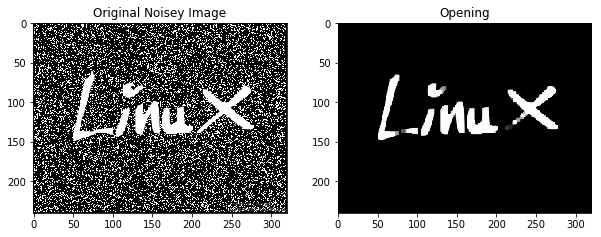

In [8]:
def grayscale_noise(image, s_vs_p, value):
    row,col = image.shape
    out = np.copy(image)
    
    num_salt = np.ceil(image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    for a,b in zip(*coords):
        out[a,b] = value
    return out

nj = grayscale_noise(img, .25, 255)
opening = cv2.morphologyEx(nj, cv2.MORPH_OPEN, kernel)

plt.subplot(1,2,1)
plt.imshow(nj, cmap='gray')
plt.title('Original Noisey Image')

plt.subplot(1,2,2)
plt.imshow(opening, cmap='gray')
plt.title('Opening');

## Closing

Now, imagine we ran an algorithm to detect letters in an image and for some reason, parts of the word linux were not detected. Using closing closes up the black holes and makes linux look better.

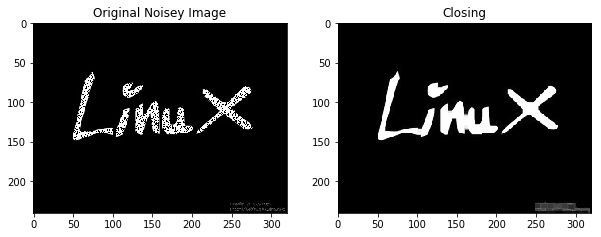

In [9]:
nj = grayscale_noise(img, .25, 0)
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

plt.subplot(1,2,1)
plt.imshow(nj, cmap='gray')
plt.title('Original Noisey Image')

plt.subplot(1,2,2)
plt.imshow(closing, cmap='gray')
plt.title('Closing');

# Thresholding

There are numerous applications where we want to have a black and white (true and false in some cases) image. Thresholding allows us to do this. 

All thresholding algorithms take a source image (src) and a threshold value (thresh) as input and produce an output image (dst) by comparing the pixel value at source pixel ( x , y ) to the threshold. If src ( x , y ) > thresh , then dst ( x , y ) is assigned a some value. Otherwise dst ( x , y ) is assigned some other value.

In its simplest form of thresholding is called Binary Thresholding. In addition to the source image (src) and threshold value (thresh), it takes another input parameter called maximum value ( maxValue ). At each pixel location (x,y) it compares the pixel value src ( x , y ) to thresh. If src ( x , y ) is greater than thresh, it sets the value of the destination image pixel dst ( x , y ) to maxValue, otherwise it sets it to zero. 

```python
# Binary Threshold
if src(x,y) > thresh
  dst(x,y) = maxValue
else
  dst(x,y) = 0
```

`cv2.threshold(image, threshold, maxValue, type)` where

- image: is the source image
- threshold: is the threshold value as defined above
- maxValue: is what the pixel is set to if the threshold is exceeded
- type: there are several types of thresholding opertions available

OpenCV offers up a few different types:

- cv2.THRESH_BINARY: pixel > threshold, set it to maxValue
- cv2.THRESH_BINARY_INV: same as above, but the output is inverted
- cv2.THRESH_TRUNC: pixel > threshold, set to threshold, but if it isn't leave it alone
- cv2.THRESH_TOZERO: pixel < threshold, set to 0, but if it is above, leave it alone
- cv2.THRESH_TOZERO_INV: same as above, but inverted

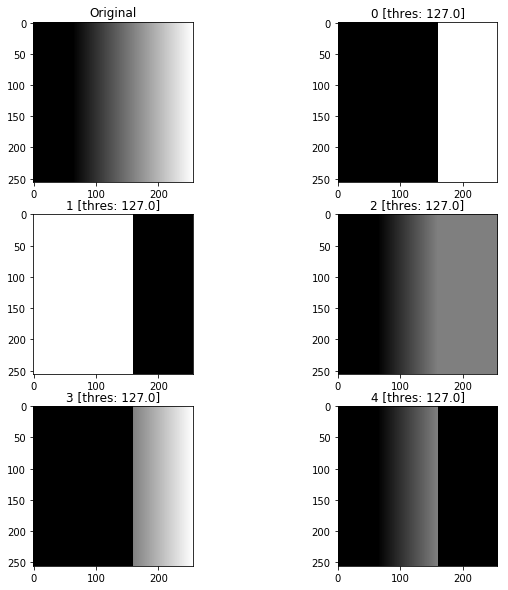

In [28]:
thresh_types = [cv2.THRESH_BINARY,
                cv2.THRESH_BINARY_INV,
                cv2.THRESH_TRUNC,
                cv2.THRESH_TOZERO,
                cv2.THRESH_TOZERO_INV]

img=cv2.imread('gradient.png')

plt.subplot(3,2,1)
plt.imshow(img)
plt.title('Original')

for i, thres in enumerate(thresh_types):
    th, dst = cv2.threshold(img, 127, 255, thres)
    plt.subplot(3,2,i+2)
    plt.imshow(dst)
    plt.title('{} [thres: {}]'.format(thres, th))

Text(0.5,1,u'Original')

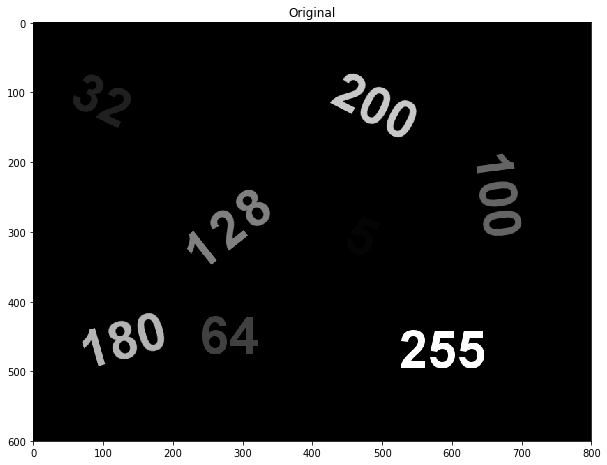

In [31]:
img=cv2.imread('numbers.png')
plt.imshow(img)
plt.title('Original')

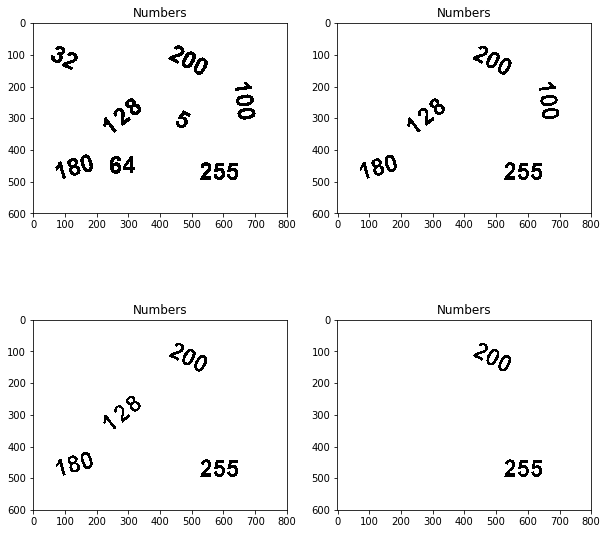

In [30]:
# let's see what playing with the threshold level does
for i, level in enumerate([0, 64, 127, 191]):
    th, dst = cv2.threshold(img, level, 255, cv2.THRESH_BINARY_INV)
    plt.subplot(2,2,i+1)
    plt.imshow(dst)
    plt.title('Numbers')

# Exercise

- Take an image (maybe a selfie) with a camera and apply some of the filters we talked about in this lesson: edge detection, sharpening filter, blurring filters
- Play with the thresholding levels and types. Try other images you have or pull off the internet ... thresholding is a very useful tool in computer vision

# Questions

1. How does convolution work according to this lesson
1. What were the 4 types of noise reduction filters talked about in this lesson and when would you use them?
1. Hoe does edge detection work, what is it looking for?
1. Given a kernel for edge detection (e.g., Sobel, Laplacian), how would you know if it detects edges in the x-direction, y-direction, or both?
1. What morphological operators were discussed, how do they work, and what applications would you use them in?
1. What are the different types of thresholding available in OpenCV and how do they work?
1. I gave you psudo code for the binary thresholding operation, write psudo code for the others.


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.